# 01 — Design, Preprocessing, Feature Engineering, and EDA

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
# ============================================================
# Setup: Paths and Imports (Update if needed)
# - Place the raw dataset under: data/student_mental_health.csv
# - This notebook will save a processed copy for other notebooks:
#   data/processed_student_mental_health.csv
# ============================================================

import os
import pandas as pd
import numpy as np

RAW_DATA_PATH = '/content/drive/MyDrive/Student-Health/Student_Mental_Health.csv'
PROCESSED_DATA_PATH = "/content/drive/MyDrive/Student-Health/processed_student_mental_health.csv"

os.makedirs("data", exist_ok=True)
os.makedirs("figures", exist_ok=True)


In [52]:
#BLOK 1 — Veri yükleme + hızlı kontrol

import pandas as pd  # veri okuma/işleme için
import numpy as np   # sayısal işlemler için

df = pd.read_csv(RAW_DATA_PATH)  # csv oku

print("Shape:", df.shape)                      # satır-sütun sayısı
print("\nColumns:\n", df.columns)              # kolon adları
print("\nHead:\n", df.head())                  # ilk 5 satır
print("\nInfo:\n")
df.info()                                      # veri tipleri / null var mı

print("\nMissing values (top):\n",
      df.isna().sum().sort_values(ascending=False).head(15))  # en çok eksik olanlar
print("\nDuplicate rows:", df.duplicated().sum())             # duplicate var mı


Shape: (101, 11)

Columns:
 Index(['Timestamp', 'Choose your gender', 'Age', 'What is your course?',
       'Your current year of Study', 'What is your CGPA?', 'Marital status',
       'Do you have Depression?', 'Do you have Anxiety?',
       'Do you have Panic attack?',
       'Did you seek any specialist for a treatment?'],
      dtype='object')

Head:
         Timestamp Choose your gender   Age What is your course?  \
0  8/7/2020 12:02             Female  18.0          Engineering   
1  8/7/2020 12:04               Male  21.0    Islamic education   
2  8/7/2020 12:05               Male  19.0                  BIT   
3  8/7/2020 12:06             Female  22.0                 Laws   
4  8/7/2020 12:13               Male  23.0         Mathemathics   

  Your current year of Study What is your CGPA? Marital status  \
0                     year 1        3.00 - 3.49             No   
1                     year 2        3.00 - 3.49             No   
2                     Year 1        3.00 

In [53]:
#BLOK 2 — Data Cleaning

import pandas as pd
import numpy as np

df = df.copy()  # güvenli kopya

#  String kolonlardaki baş/son boşlukları temizle
obj_cols = df.select_dtypes(include="object").columns
for col in obj_cols:
    df[col] = df[col].astype(str).str.strip()

#  Duplicate yok ama yine de güvenli olsun
df = df.drop_duplicates()

#  Age'i numeric yap (zaten float ama garanti)
df["Age"] = pd.to_numeric(df["Age"], errors="coerce")

#  Eksik değerleri doldur
# Numeric → median
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Categorical → mode
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Shape after cleaning:", df.shape)
print("Total missing values after cleaning:", df.isna().sum().sum())

Shape after cleaning: (101, 11)
Total missing values after cleaning: 0


In [54]:
# ============================================================
# BLOK 3: FEATURE ENGINEERING
# Amaç:
# - Veri setinde doğrudan "stress level" bulunmadığı için,
#   psikolojik göstergelerden (depression, anxiety, panic)
#   türetilmiş bir stres göstergesi (stress_score) oluşturmak.
# - Ayrıca yüksek stres yaşayıp profesyonel destek almayan
#   öğrencileri yakalayacak bir risk değişkeni üretmek.
# Bu adım, Stage 3 - Data Preprocessing gereksinimini karşılar.
# ============================================================

df = df.copy()  # Orijinal veri setini korumak için kopya alıyoruz

# ------------------------------------------------------------
# 1) Yes / No cevaplarını binary (0/1) forma dönüştürme
# Bu dönüşüm, makine öğrenmesi modellerinin çalışabilmesi için gereklidir.
# ------------------------------------------------------------
yn_map = {"Yes": 1, "No": 0}

df["depression_bin"] = df["Do you have Depression?"].map(yn_map)   # Depression -> 0/1
df["anxiety_bin"]    = df["Do you have Anxiety?"].map(yn_map)      # Anxiety -> 0/1
df["panic_bin"]      = df["Do you have Panic attack?"].map(yn_map) # Panic attack -> 0/1
df["treatment_bin"]  = df["Did you seek any specialist for a treatment?"].map(yn_map)
# Treatment seeking -> 0/1

# ------------------------------------------------------------
# 2)Stress Score (0–3)
# Depression, anxiety ve panic attack değişkenlerinin toplamı,
# öğrencinin genel psikolojik stres seviyesini temsil eder.
# ------------------------------------------------------------
df["stress_score"] = (
    df["depression_bin"] +
    df["anxiety_bin"] +
    df["panic_bin"]
)

# ------------------------------------------------------------
# 3)High Stress & No Treatment Flag
# Amaç:
# - Stres seviyesi yüksek (>=2) olup
# - Profesyonel destek almayan öğrencileri belirlemek
# Bu değişken riskli öğrenci grubunu temsil eder.
# ------------------------------------------------------------
df["high_stress_no_treatment"] = (
    (df["stress_score"] >= 2) &
    (df["treatment_bin"] == 0)
).astype(int)

# ------------------------------------------------------------
# 4) Oluşturulan yeni feature'ların kontrolü
# Dağılım ve temel istatistikler incelenir.
# ------------------------------------------------------------
print("Stress score distribution:")
print(df["stress_score"].value_counts().sort_index())

print("\nHigh stress & no treatment counts:")
print(df["high_stress_no_treatment"].value_counts())

print("\nNew feature summary:")
print(df[["stress_score", "high_stress_no_treatment"]].describe())


Stress score distribution:
stress_score
0    37
1    36
2    18
3    10
Name: count, dtype: int64

High stress & no treatment counts:
high_stress_no_treatment
0    79
1    22
Name: count, dtype: int64

New feature summary:
       stress_score  high_stress_no_treatment
count    101.000000                101.000000
mean       1.009901                  0.217822
std        0.974629                  0.414824
min        0.000000                  0.000000
25%        0.000000                  0.000000
50%        1.000000                  0.000000
75%        2.000000                  0.000000
max        3.000000                  1.000000


In [55]:
# ============================================================
# BLOK 4: TARGET VARIABLE DEFINITION (ACADEMIC PERFORMANCE)
# Amaç:
# - Akademik başarıyı (Academic Performance) modellemek için
#   uygun bir hedef değişken (target) oluşturmak.
# - CGPA kategorik olduğu için binary sınıflandırma tercih edilmiştir.
# ============================================================

df = df.copy()  # güvenli kopya

# ------------------------------------------------------------
# 1) Yüksek akademik başarı tanımı
# CGPA aralığı "3.50 - 4.00" olan öğrenciler:
#   High Academic Performance -> 1
# Diğer tüm CGPA aralıkları:
#   Low/Medium Performance -> 0
# ------------------------------------------------------------
df["high_cgpa"] = (df["What is your CGPA?"] == "3.50 - 4.00").astype(int)

# ------------------------------------------------------------
# 2) Target değişkeninin dağılımını kontrol et
# Bu adım, sınıf dengesizliği olup olmadığını anlamak için kritiktir.
# ------------------------------------------------------------
print("Original CGPA distribution:")
print(df["What is your CGPA?"].value_counts())

print("\nHigh CGPA (target) distribution:")
print(df["high_cgpa"].value_counts())

print("\nHigh CGPA ratio:")
print(df["high_cgpa"].value_counts(normalize=True))


Original CGPA distribution:
What is your CGPA?
3.50 - 4.00    48
3.00 - 3.49    43
2.50 - 2.99     4
0 - 1.99        4
2.00 - 2.49     2
Name: count, dtype: int64

High CGPA (target) distribution:
high_cgpa
0    53
1    48
Name: count, dtype: int64

High CGPA ratio:
high_cgpa
0    0.524752
1    0.475248
Name: proportion, dtype: float64


In [56]:
# ============================================================
# BLOK 4.1: CGPA STANDARDIZATION
# Amaç:
# - Aynı CGPA aralığını temsil eden farklı string ifadeleri
#   tek bir standart forma dönüştürmek.
# - Hatalı sınıf bölünmelerini önlemek.
# ============================================================

df = df.copy()

# CGPA string'lerini normalize et
df["What is your CGPA?"] = (
    df["What is your CGPA?"]
    .str.replace(" ", "", regex=False)   # tüm boşlukları kaldır
)

# Standart CGPA etiketleri
cgpa_map = {
    "3.50-4.00": "3.50-4.00",
    "3.00-3.49": "3.00-3.49",
    "2.50-2.99": "2.50-2.99",
    "2.00-2.49": "2.00-2.49",
    "0-1.99": "0-1.99"
}

df["cgpa_clean"] = df["What is your CGPA?"].map(cgpa_map)

# Target'ı tekrar tanımla
df["high_cgpa"] = (df["cgpa_clean"] == "3.50-4.00").astype(int)

# Kontrol
print("Clean CGPA distribution:")
print(df["cgpa_clean"].value_counts())

print("\nHigh CGPA distribution (clean):")
print(df["high_cgpa"].value_counts())


Clean CGPA distribution:
cgpa_clean
3.50-4.00    48
3.00-3.49    43
2.50-2.99     4
0-1.99        4
2.00-2.49     2
Name: count, dtype: int64

High CGPA distribution (clean):
high_cgpa
0    53
1    48
Name: count, dtype: int64


Target distribution (count & percent):
                count  percent
Low/Medium (0)     53    52.48
High (1)           48    47.52


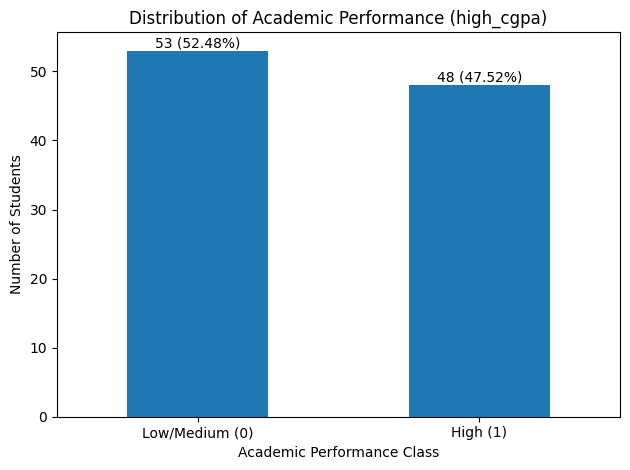

In [57]:
# ============================================================

# BLOK 5: TARGET VARIABLE DISTRIBUTION (IMPROVED)

# Amaç:
# - Akademik başarı (high_cgpa) sınıflarının dağılımını incelemek
# - Sınıf dengesizliği (class imbalance) olup olmadığını kontrol etmek
# - Grafiği rapor/sunum kalitesinde göstermek (count + percentage)

# ============================================================

import matplotlib.pyplot as plt
import pandas as pd

# 1) Sınıf sayıları ve yüzdeleri
counts = df["high_cgpa"].value_counts().sort_index()
percents = df["high_cgpa"].value_counts(normalize=True).sort_index()

summary = pd.DataFrame({
    "count": counts,
    "percent": (percents * 100).round(2)
})

# 0/1 etiketlerini daha okunur hale getir (rapor için)
summary.index = ["Low/Medium (0)", "High (1)"]

print("Target distribution (count & percent):")
print(summary)

# 2) Bar plot (etiketleri daha anlaşılır yap)
plt.figure()
ax = summary["count"].plot(kind="bar")

plt.xlabel("Academic Performance Class")
plt.ylabel("Number of Students")
plt.title("Distribution of Academic Performance (high_cgpa)")

# 3) Barların üzerine count + yüzde yaz
for i, v in enumerate(summary["count"].values):
    pct = summary["percent"].values[i]
    ax.text(i, v + 0.5, f"{v} ({pct}%)", ha="center")

plt.xticks(rotation=0)   # etiketler düz dursun
plt.tight_layout()       # taşmaları engelle
plt.show()


Stress score distribution:
stress_score
0    37
1    36
2    18
3    10
Name: count, dtype: int64


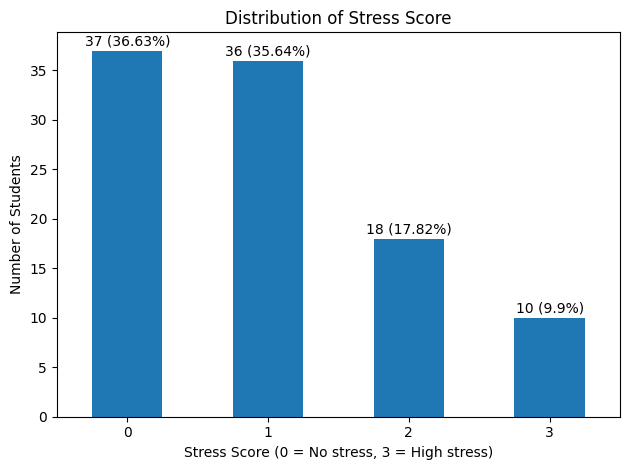

In [58]:
# ============================================================
# BLOK 6: STRESS SCORE DISTRIBUTION
# Amaç:
# - Feature engineering aşamasında oluşturulan stress_score
#   değişkeninin dağılımını incelemek
# - Öğrencilerin genel stres profilini görselleştirmek
# - EDA kapsamında stres seviyelerinin yayılımını analiz etmek
# ============================================================

import matplotlib.pyplot as plt

# Stress score sayımlarını al (0,1,2,3 şeklinde sıralı)
stress_counts = df["stress_score"].value_counts().sort_index()

print("Stress score distribution:")
print(stress_counts)

# Bar plot
plt.figure()
stress_counts.plot(kind="bar")

plt.xlabel("Stress Score (0 = No stress, 3 = High stress)")
plt.ylabel("Number of Students")
plt.title("Distribution of Stress Score")

# Barların üzerine öğrenci sayılarını yaz
total = stress_counts.sum()

for i, v in enumerate(stress_counts.values):
    pct = round((v / total) * 100, 2)
    plt.text(i, v + 0.5, f"{v} ({pct}%)", ha="center")

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


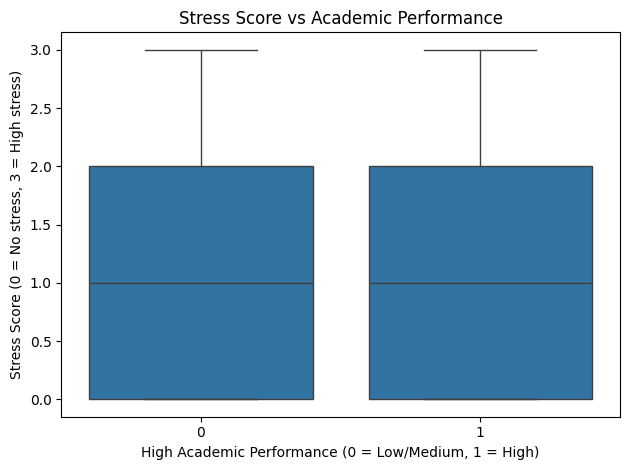

In [59]:
# ============================================================
# BLOK 7: STRESS SCORE vs ACADEMIC PERFORMANCE
# Amaç:
# - Öğrencilerin stres seviyeleri (stress_score) ile
#   akademik başarıları (high_cgpa) arasındaki ilişkiyi incelemek
# - Yüksek stresin akademik performans üzerinde
#   potansiyel bir etkisi olup olmadığını görselleştirmek
# - Modelleme (Stage 5) öncesi ilk hipotezi oluşturmak
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot: stress_score dağılımı, akademik başarı sınıflarına göre
plt.figure()
sns.boxplot(
    x="high_cgpa",
    y="stress_score",
    data=df
)

# Eksen ve başlık açıklamaları
plt.xlabel("High Academic Performance (0 = Low/Medium, 1 = High)")
plt.ylabel("Stress Score (0 = No stress, 3 = High stress)")
plt.title("Stress Score vs Academic Performance")

plt.tight_layout()
plt.show()


Academic performance distribution within risk groups:
high_cgpa                        0         1
high_stress_no_treatment                    
0                         0.518987  0.481013
1                         0.545455  0.454545


<Figure size 640x480 with 0 Axes>

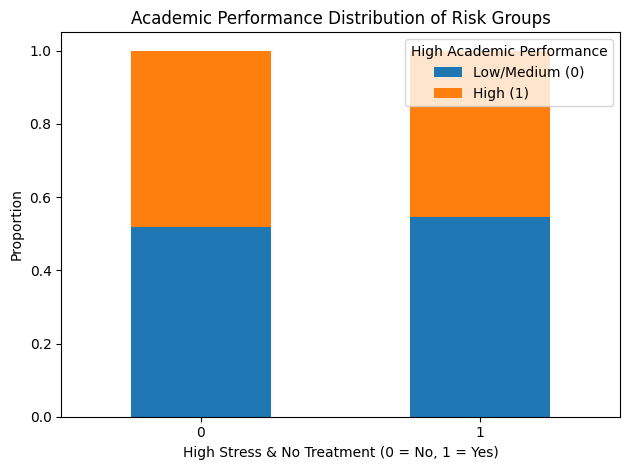

In [60]:
# ============================================================
# BLOK 8: RISK GROUP ANALYSIS
# Amaç:
# - Yüksek stres yaşayıp profesyonel destek almayan öğrencilerin
#   akademik performanslarını incelemek
# - Riskli öğrencilerin akademik başarı açısından
#   dezavantajlı olup olmadığını analiz etmek
# ============================================================

import matplotlib.pyplot as plt
import pandas as pd

# ------------------------------------------------------------
# 1) Risk grubu ile akademik performans arasındaki ilişki
# Normalize = "index" → her grubun kendi içindeki oranlarını verir
# ------------------------------------------------------------
risk_table = pd.crosstab(
    df["high_stress_no_treatment"],  # 0 = riskli değil, 1 = riskli
    df["high_cgpa"],                 # 0 = low/medium, 1 = high
    normalize="index"
)

print("Academic performance distribution within risk groups:")
print(risk_table)

# ------------------------------------------------------------
# 2) Görselleştirme: Stacked bar plot
# ------------------------------------------------------------
plt.figure()
risk_table.plot(kind="bar", stacked=True)

plt.xlabel("High Stress & No Treatment (0 = No, 1 = Yes)")
plt.ylabel("Proportion")
plt.title("Academic Performance Distribution of Risk Groups")
plt.legend(
    title="High Academic Performance",
    labels=["Low/Medium (0)", "High (1)"],
    loc="upper right"
)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Correlation Matrix:
                               Age  stress_score  high_stress_no_treatment  \
Age                       1.000000     -0.047478                 -0.119415   
stress_score             -0.047478      1.000000                  0.761370   
high_stress_no_treatment -0.119415      0.761370                  1.000000   
high_cgpa                 0.034328      0.031172                 -0.021876   

                          high_cgpa  
Age                        0.034328  
stress_score               0.031172  
high_stress_no_treatment  -0.021876  
high_cgpa                  1.000000  


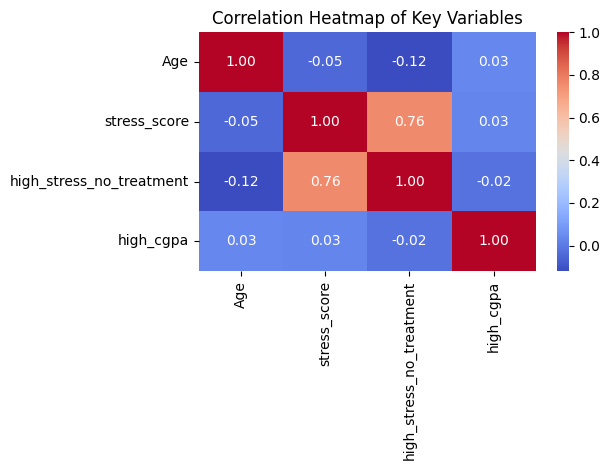

In [61]:
# ============================================================
# BLOK 9: CORRELATION ANALYSIS
# Amaç:
# - Sayısal ve binary değişkenler arasındaki ilişkileri incelemek
# - Stress score, akademik performans ve yaş arasındaki
#   olası doğrusal ilişkileri analiz etmek
# - Modelleme öncesi değişkenler arası ilişkiyi anlamak
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) Korelasyon için kullanılacak değişkenler
# (Sadece numeric / binary değişkenler)
# ------------------------------------------------------------
corr_features = [
    "Age",
    "stress_score",
    "high_stress_no_treatment",
    "high_cgpa"
]

# Korelasyon matrisi
corr_matrix = df[corr_features].corr()

print("Correlation Matrix:")
print(corr_matrix)

# ------------------------------------------------------------
# 2) Korelasyon ısı haritası (heatmap)
# ------------------------------------------------------------
plt.figure()
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("Correlation Heatmap of Key Variables")
plt.tight_layout()
plt.show()


In [62]:
# ============================================================
# BLOK 9.1: ATTRIBUTE SKEWNESS ANALYSIS
# Amaç:
# - Sayısal değişkenlerin dağılım eğriliğini (skewness) incelemek
# - Verinin simetrik mi yoksa çarpık mı olduğunu belirlemek
# ============================================================


skew_values = df[["Age", "stress_score"]].skew()

print("Skewness values:")
print(skew_values)


Skewness values:
Age             0.393133
stress_score    0.641107
dtype: float64


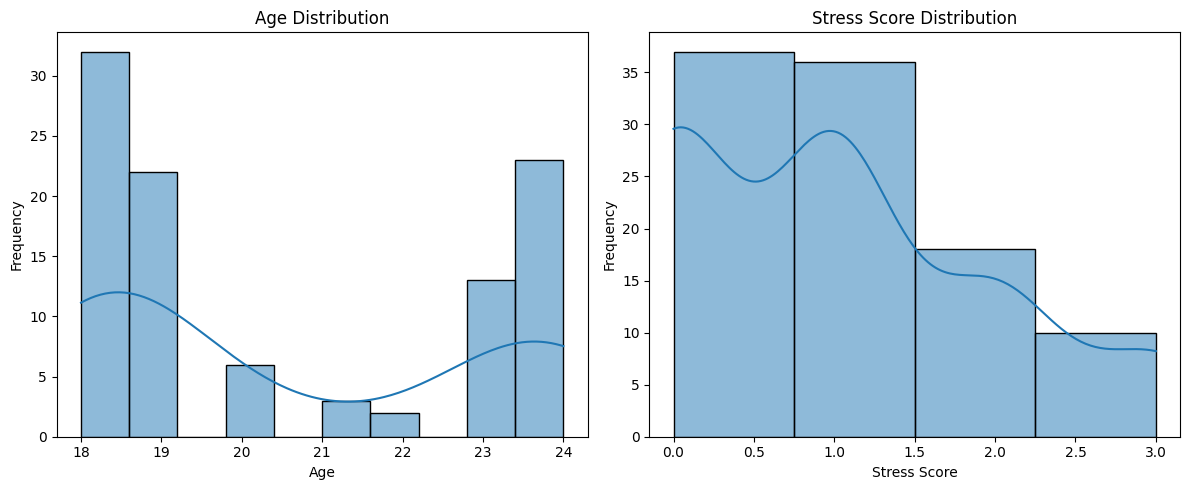

In [63]:
# ============================================================
# BLOK 9.2: SKEWNESS VISUALIZATION
# Amaç:
# - Age ve stress_score değişkenlerinin dağılımını görselleştirmek
# - Skewness (çarpıklık) değerlerini görsel olarak desteklemek
# ============================================================

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,5))

# Age distribution
plt.subplot(1, 2, 1)
sns.histplot(df["Age"], kde=True, bins=10)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")

# Stress score distribution
plt.subplot(1, 2, 2)
sns.histplot(df["stress_score"], kde=True, bins=4)
plt.title("Stress Score Distribution")
plt.xlabel("Stress Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [64]:
# ============================================================
# Save processed dataset for reproducibility
# ============================================================

df.to_csv(PROCESSED_DATA_PATH, index=False)
print(f"Saved processed dataset to: {PROCESSED_DATA_PATH}")


Saved processed dataset to: /content/drive/MyDrive/Student-Health/processed_student_mental_health.csv
